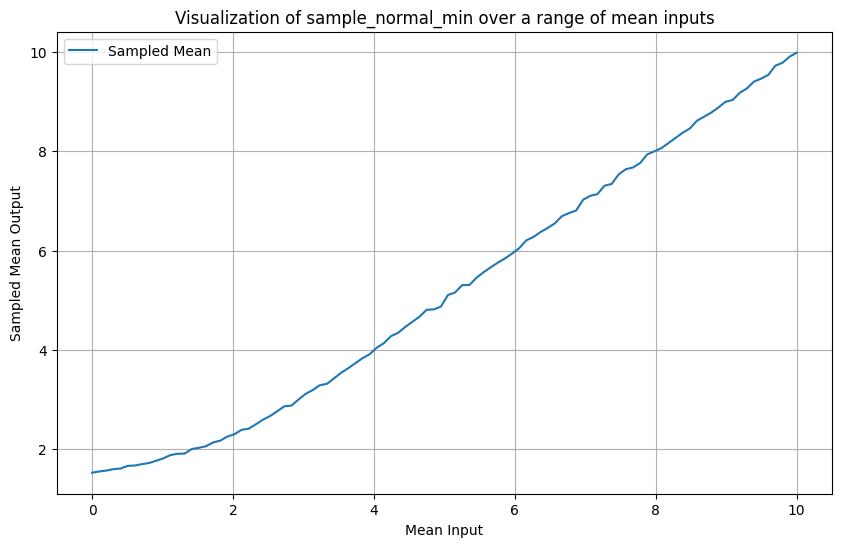

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from cabm.agent_functions import sample_normal_min

def visualize_sample_normal_min(mean_range, std_dev=1.0, min_value=1.0, override=0, num_samples=1000):
    samples = []
    means = []

    for mean in mean_range:
        mean_samples = [sample_normal_min(mean, std_dev, min_value, override) for _ in range(num_samples)]
        samples.append(np.mean(mean_samples))
        means.append(mean)

    plt.figure(figsize=(10, 6))
    plt.plot(means, samples, label='Sampled Mean')
    plt.xlabel('Mean Input')
    plt.ylabel('Sampled Mean Output')
    plt.title('Visualization of sample_normal_min over a range of mean inputs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the range of mean values
mean_range = np.linspace(0, 10, 100)

# Visualize the function
visualize_sample_normal_min(mean_range)

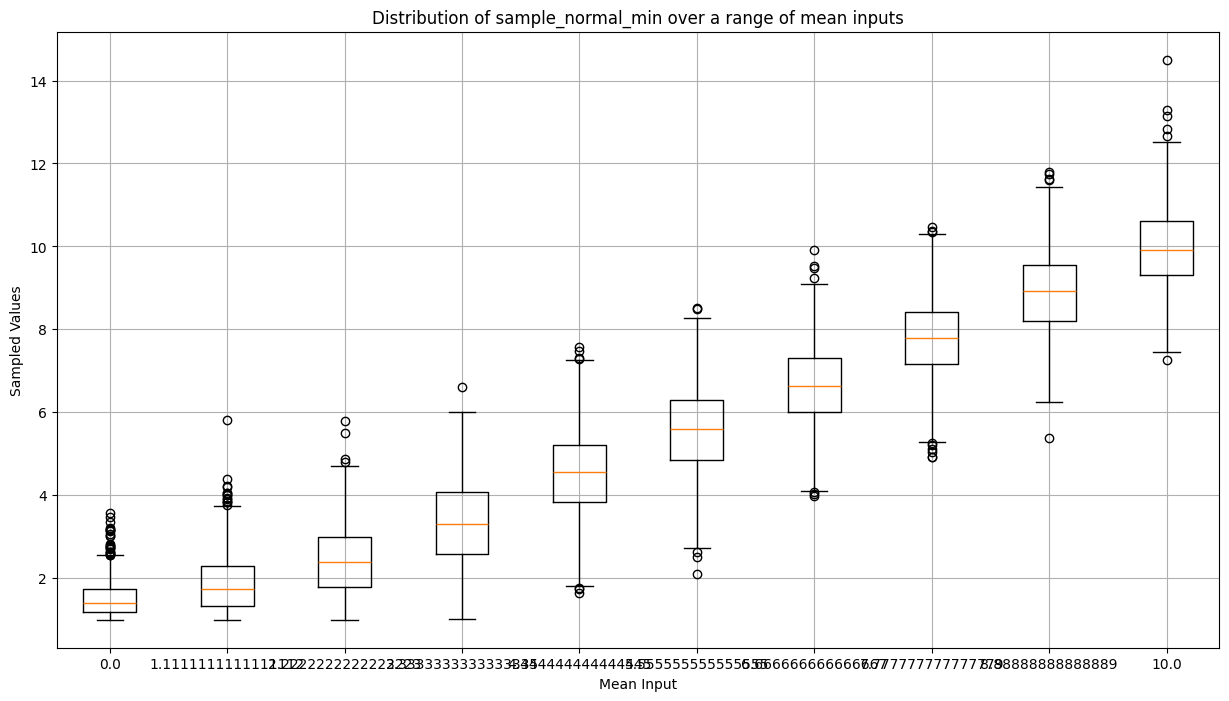

In [5]:
def visualize_sample_normal_min(mean_range, std_dev=1.0, min_value=1.0, override=0, num_samples=1000):
    all_samples = []

    for mean in mean_range:
        mean_samples = [sample_normal_min(mean, std_dev, min_value, override) for _ in range(num_samples)]
        all_samples.append(mean_samples)

    plt.figure(figsize=(15, 8))
    plt.boxplot(all_samples, positions=mean_range, widths=0.5)
    plt.xlabel('Mean Input')
    plt.ylabel('Sampled Values')
    plt.title('Distribution of sample_normal_min over a range of mean inputs')
    plt.grid(True)
    plt.show()

# Define the range of mean values
mean_range = np.linspace(0, 10, 10)

# Visualize the function
visualize_sample_normal_min(mean_range)